In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step 0 - install and import dependencies**

In [2]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 4.4 MB/s 
     |████████████████████████████████| 743 kB 62.9 MB/s 
     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 86 kB 3.1 MB/s 
     |████████████████████████████████| 1.1 MB 32.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=1b6bf71c06db2d9e6a6b349997927c5907755deb7b55287dd60f233dc88dd53b
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=a373195b0013ff1d6a307467c1d5b5c0a87eef1b76476ea6514120887f787c59
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [3]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [4]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [5]:
df = pd.read_csv("/content/drive/MyDrive/BADS7105 - CRM/Voice of Customer/Wongnai Reviews - Small.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review ID  300 non-null    int64 
 1   Review     300 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


In [30]:
df.head()

,Review ID,Review,KMeans ID,Agglomerative ID
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...,0,0
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...,0,0
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...,1,0
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,3,0
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...,3,0


**Step 1 - document embedding and dimension reduction**

In [7]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [8]:
embed_comments_array.shape

(300, 512)

In [9]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

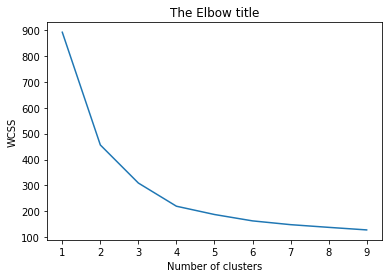

In [10]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [11]:
#run kmeans with no. of clusters you see fit the most

k = 4
kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [12]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [13]:
df_kmeans

,KMeans ID,texts
0,0,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
3,3,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...


In [14]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [15]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [16]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [17]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [18]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [19]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [20]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'ๆ', 'ๆๆ', 'ๆๆๆ', "['", 'รีวิว', 'ดิชั้น', "','", ')', '(', 'ช้ัน', 'ดิ', 'เรื่อง', 'review', 'nTamp', 'tamp', '-', 'ม่ะ', 'จัย', 'เมนู', 'เห๊', 'อะ', 'เแา', 'ึะ', 'ม', ':', "ๆ']", 
                 "กิน", 'ผม', 'กก', 'อาหาร', 'ร้านอาหาร', 'ทาน', 'น', 'ศ', 'นึง', 'คน', 'นะคะ', 'จาน', 'จ่า', 'ยัน', 'สรุก', 'กา', 'บอ', 'สวัสดี', 'าน', 'ส', 'ไหม', 'นขา', 'อ', 'กร้าน', 'รา', 'ห', 'ร้า', 'จ', 'ท', 'ซื้อ', 'ชื่อ', 
                 'นอ', 'อย', 'เดือน', 'แวะ', 'ว', 'ค', 'ข', 'ร้านกาแฟ', 'กาแฟ', 'ร', 'อี', ' เด', 'รี่']
screening_words = stopwords + removed_words

new_words = {"สตารบัก", "เดลิเวอรี", "อเมซอน", "ชานมไข่มุก", "หัวหิน", "ถูก", "แพง"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [21]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [22]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[ชอบ, Macchiato, เป็นประจำ, เด, ArtofCoffeeKas...","[(ชอบ, 8), (คาเฟ่, 6), (น่ารัก, 5), (นั่ง, 5),..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(อร่อย, 6), (ซอย, 6), (ราคา, 5), (เพื่อน, 4),..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า, บ่าย, เย็...","[(ชา, 9), (ชานมไข่มุก, 9), (ไข่มุก, 5), (นม, 5..."
3,3,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, ไช, อบ, เวี...","[(อร่อย, 9), (บ้าน, 5), (ชอบ, 4), (มีโอกาส, 3)..."


In [34]:
#show top keywords of each cluster

top_N_words = 11

for i in range(0, len(df_kmeans)):
  print(f"Topic : {i+1}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Topic : 1

Most common words include : [('ชอบ', 8), ('คาเฟ่', 6), ('น่ารัก', 5), ('นั่ง', 5), ('เจอ', 5), ('เบเกอรี่', 4), ('พาย', 4), ('วัง', 4), ('แนว', 4), ('แถว', 4), ('อเมซอน', 4)]

Topic : 2

Most common words include : [('อร่อย', 6), ('ซอย', 6), ('ราคา', 5), ('เพื่อน', 4), ('ส้มตำ', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('ไร้', 3), ('ยำ', 3), ('เก่าแก่', 3)]

Topic : 3

Most common words include : [('ชา', 9), ('ชานมไข่มุก', 9), ('ไข่มุก', 5), ('นม', 5), ('เครื่องดื่ม', 4), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3), ('ไต้หวัน', 3), ('เติม', 2), ('ชาเขียว', 2)]

Topic : 4

Most common words include : [('อร่อย', 9), ('บ้าน', 5), ('ชอบ', 4), ('มีโอกาส', 3), ('ถนน', 3), ('คิว', 3), ('ครั้งแรก', 3), ('เลือก', 3), ('ลอง', 3), ('หา', 3), ('ดี', 3)]



Refer KMeans

Topic 1 :   คาเฟ่/เบเกอรี่ บรรยากาศดี น่ารัก

Topic 2 :   ร้านเก่าแก่รสชาติอร่อย

Topic 3 :   ร้าน ชา/ชานมไข่มุก น่าลอง

Topic 4 :   ร้าน Local สไตล์บ้านๆน่าลอง

**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [24]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters = 4, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [25]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])

k = 4
for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [26]:
df_Agglomerative

,Agglomerative ID,texts
0,0,['เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึง...
1,1,['ประโยชน์ของน้ำแตงโมปั่น\nแตงโม มีมากมายหลายพ...
2,2,['ปังภูเขาไฟ กับอ่กาศร้อนๆ เข้ากันฝุดๆ\nหวานๆอ...
3,3,['เรื่องขนม ไม่ค่อยสันทัด ดังนั้นขอreviewเฉพาะ...


In [27]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [28]:
#show top keywords of each cluster

top_N_words = 15

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 509), ('รสชาติ', 414), ('ดี', 348), ('สั่ง', 302), ('ราคา', 275), ('บาท', 242), ('ชอบ', 232), ('ชา', 213), ('หวาน', 206), ('นั่ง', 205), ('ลอง', 178), ('บรรยากาศ', 152), ('ดู', 148), ('หอม', 137), ('เค้า', 136)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3), ('ร่างกาย', 3), ('เมล็ด', 2), ('มีรส', 2), ('หวาน', 2), ('เย็น', 2), ('ยังมี', 2)]

Cluster ID : 2

Most common words include : [('ปัง', 4), ('ภูเขาไฟ', 3), ('อ่', 1), ('ร้อน', 1), ('เข้ากัน', 1), ('ฝุดๆ', 1), ('หวาน', 1), ('อร่อย', 1), ('ดีแต่', 1), ('เย็น', 1), ('ๆเริศ', 1), ('น่ากิน', 1), ('บิ๊ก', 1), ('เล่น', 1), ('อิ่ม', 1)]

Cluster ID : 3

Most common words include : [('นม', 3), ('แน่น', 2), ('เท', 2), ('แก้', 2), ('ขนม', 1), ('สันทัด', 1), ('ดังนั้น', 1), ('เฉพาะเรื่อง', 1), ('กาแฟร้อน', 1), ('มากเกินไป', 1), ('โถม', 1), ('ย้ำ', 1), ('รอบ', 1), ('

**Step 4 - result discussion**

Refer KMeans

Topic 1 :   คาเฟ่/เบเกอรี่ บรรยากาศดี น่ารัก

Topic 2 :   ร้านเก่าแก่รสชาติอร่อย

Topic 3 :   ร้าน ชา/ชานมไข่มุก น่าลอง

Topic 4 :   ร้าน Local สไตล์บ้านๆน่าลอง